In [1]:
import osnap
import libpysal as lps
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_context('notebook')

/Users/knaaptime/anaconda/lib/python3.6/site-packages/libpysal/io/iohandlers/__init__.py:25: UserWarning: SQLAlchemy and Geomet not installed, database I/O disabled
  warnings.warn('SQLAlchemy and Geomet not installed, database I/O disabled')
/Users/knaaptime/anaconda/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


## Create a dataset by passing a boundary

In [2]:
va = gpd.read_file(lps.examples.get_path('virginia.shp'))

In [3]:
virginia = osnap.data.Dataset(name='Virginia', source='ltdb', boundary=va)

The `Dataset` class stores state, county, and tract boundaries, available as `.states`, `.counties`, and `.tracts`. The boundaries are `geopandas.GeoDataFrame`s, so all the typical GeoDataFrame methods like plotting are available

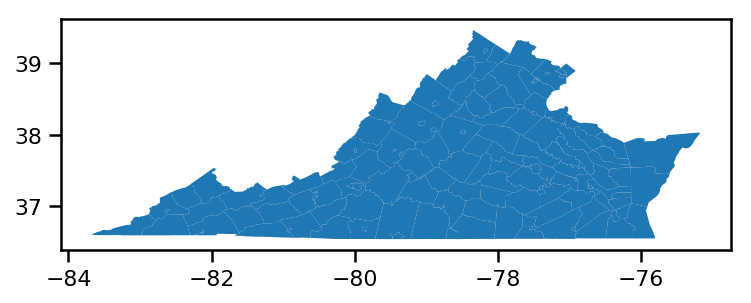

In [4]:
virginia.counties.plot()

`Dataset` stores tabular data from the designated source, available under the `data` attribute as a long-form `pandas.DataFrame`

In [5]:
virginia.data.head()

,n_asian_under_15,n_black_under_15,n_hispanic_under_15,n_native_under_15,n_white_under_15,n_persons_under_18,n_asian_over_60,n_black_over_60,n_hispanic_over_60,n_native_over_60,...,n_widowed_divorced,n_white_persons,year,p_nonhisp_white_persons,p_white_over_60,p_black_over_60,p_hispanic_over_60,p_native_over_60,p_asian_over_60,p_disabled
geoid,,,,,,,,,,,,,,,,,,,,,
11001000802,NaN,4.0,NaN,NaN,460.0,524.0,NaN,8.0,NaN,NaN,...,450.0,3022.0,1970,NaN,27.0,0.0,NaN,NaN,NaN,4.0
51003010402,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,...,0.0,0.0,1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51003010602,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51003010901,NaN,0.0,NaN,NaN,2.0,3.0,NaN,0.0,NaN,NaN,...,1.0,12.0,1970,NaN,17.0,0.0,NaN,NaN,NaN,1.0
51003010903,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,...,0.0,1.0,1970,NaN,17.0,0.0,NaN,NaN,NaN,1.0


For convenience, a plotting method is implemented that accepts a column name and a year. County boundaries can be turned off py passing ` plot_counties=False`

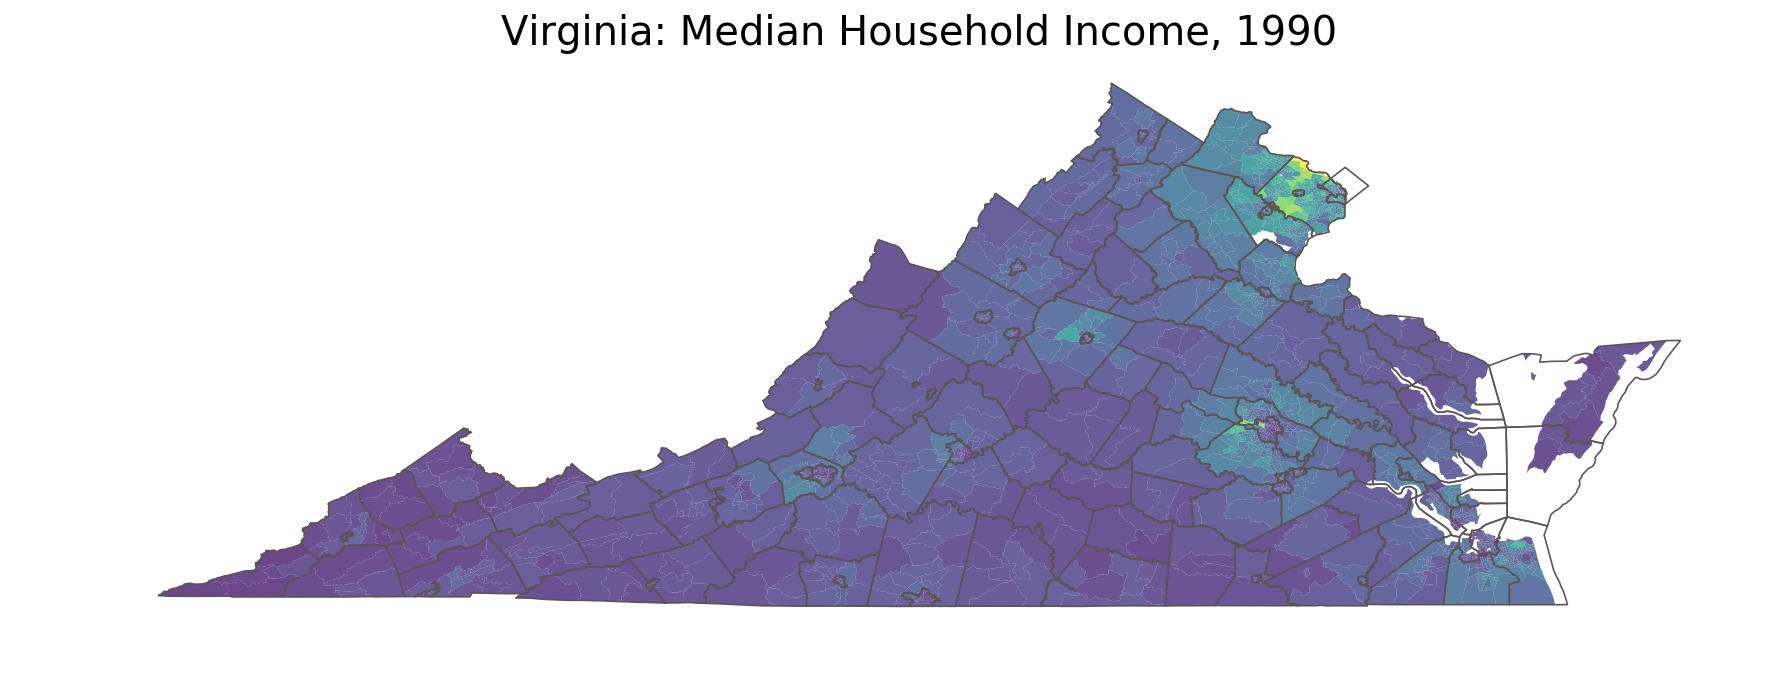

In [6]:
virginia.plot(column='median_household_income', year=1990)

## Create a dataset by passing a list of state/county FIPS

Counties are optional, so statewide or regionwide datasets can be created by passing only states

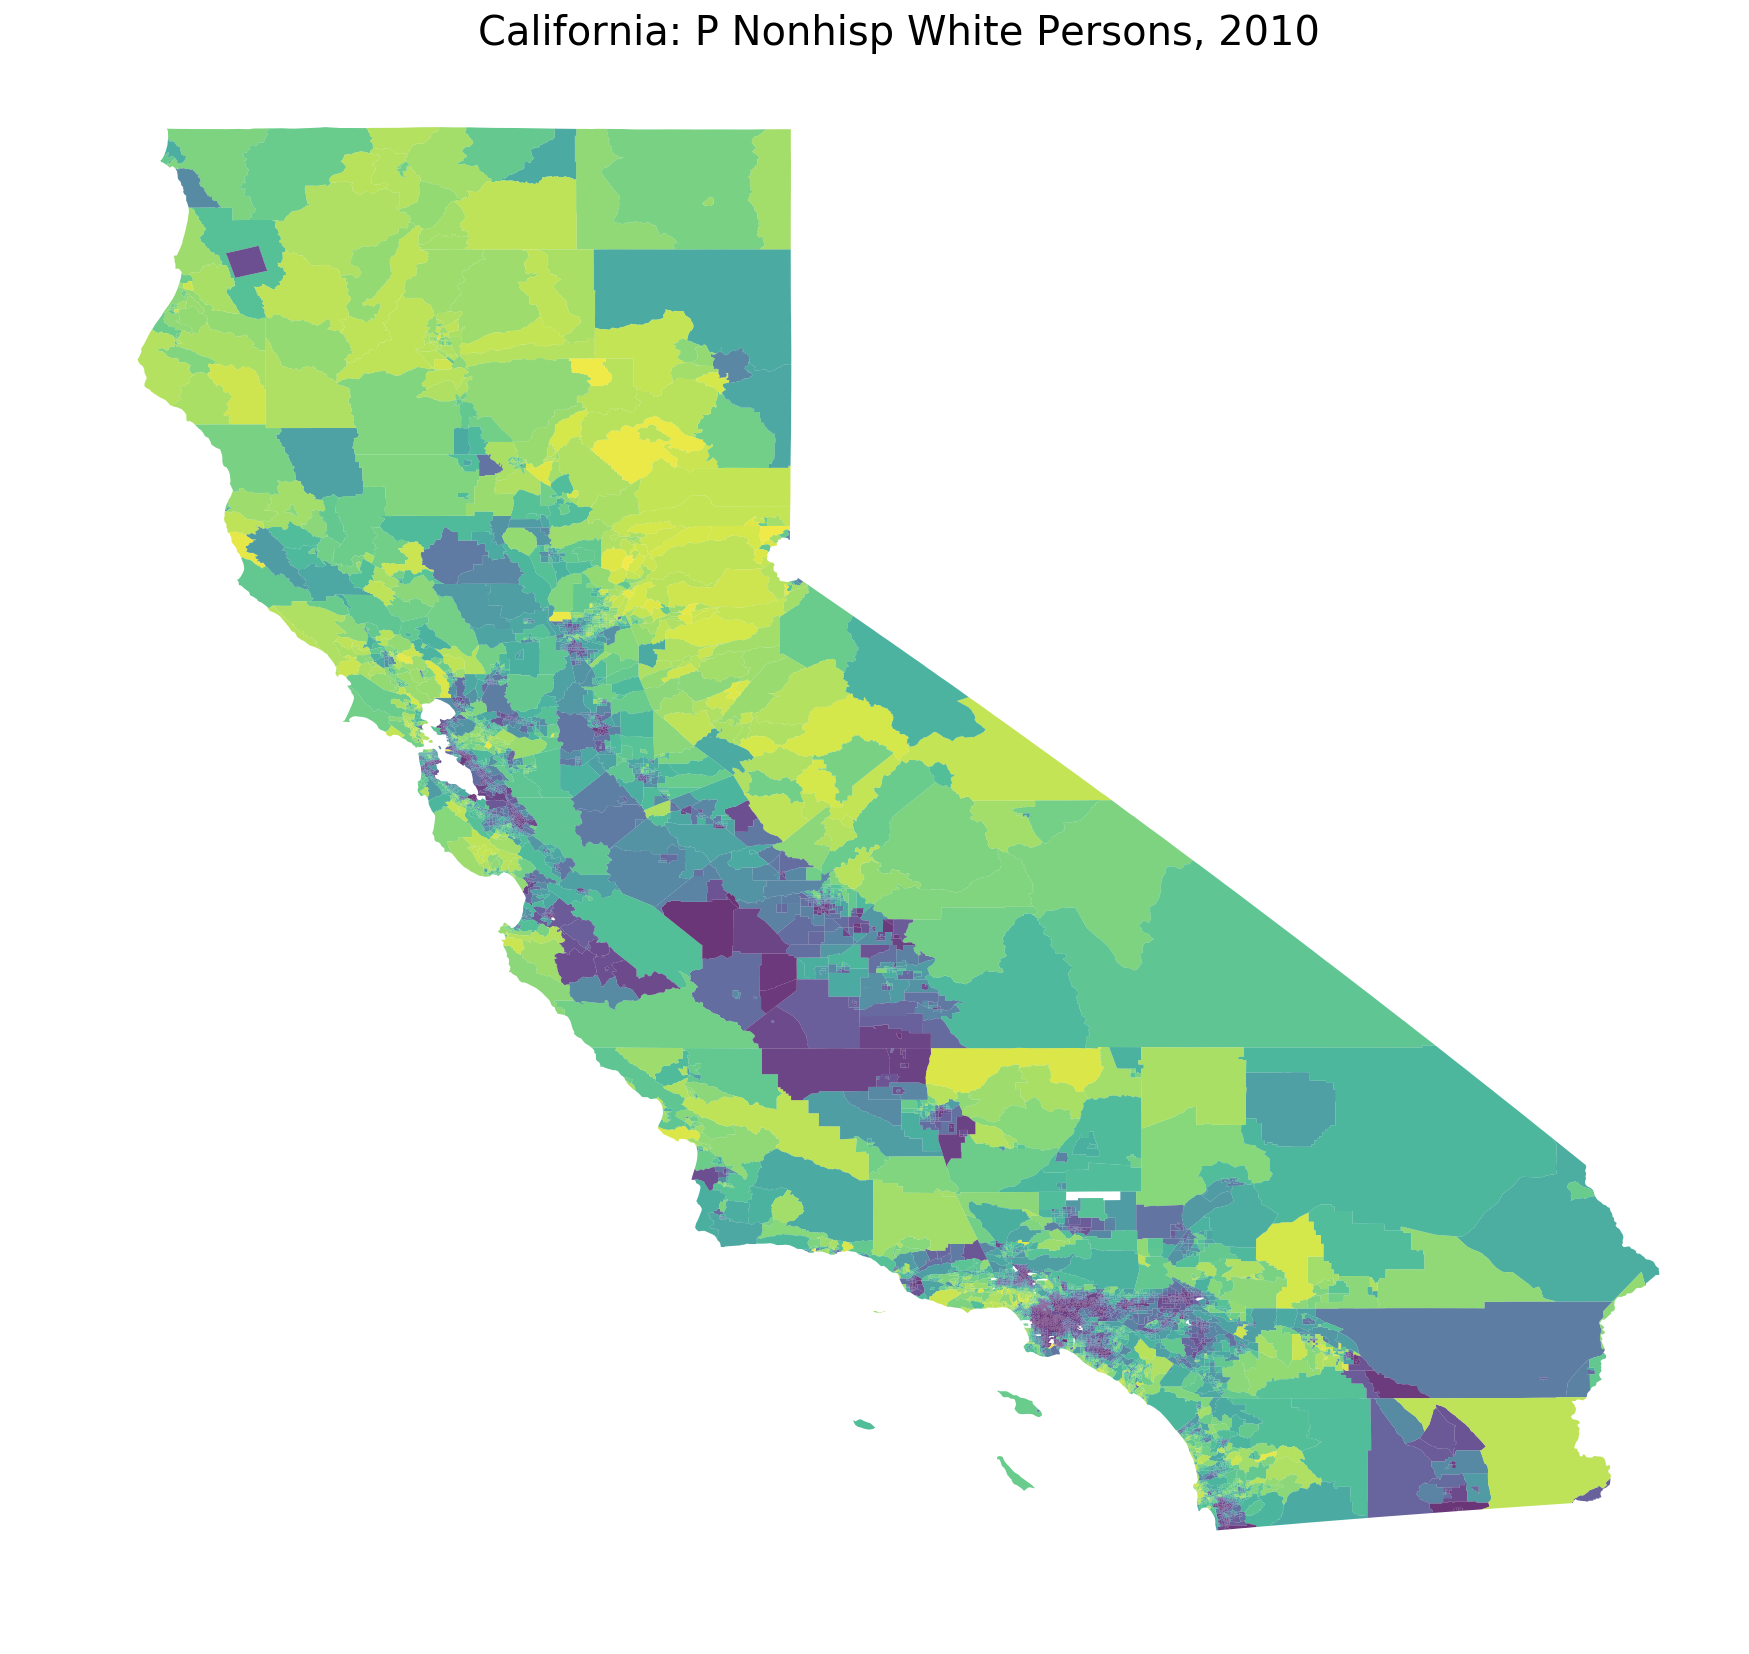

In [7]:
california = osnap.data.Dataset(name='California', source='ltdb', states='06') 
california.plot(column='p_nonhisp_white_persons', year=2010, plot_counties=False)

In [8]:
balt_counties = ['003', '005', '510', '013', '025', '027', '035']
baltimore = osnap.data.Dataset(name='Baltimore Metro Region', states='24', source='ltdb', counties=balt_counties)

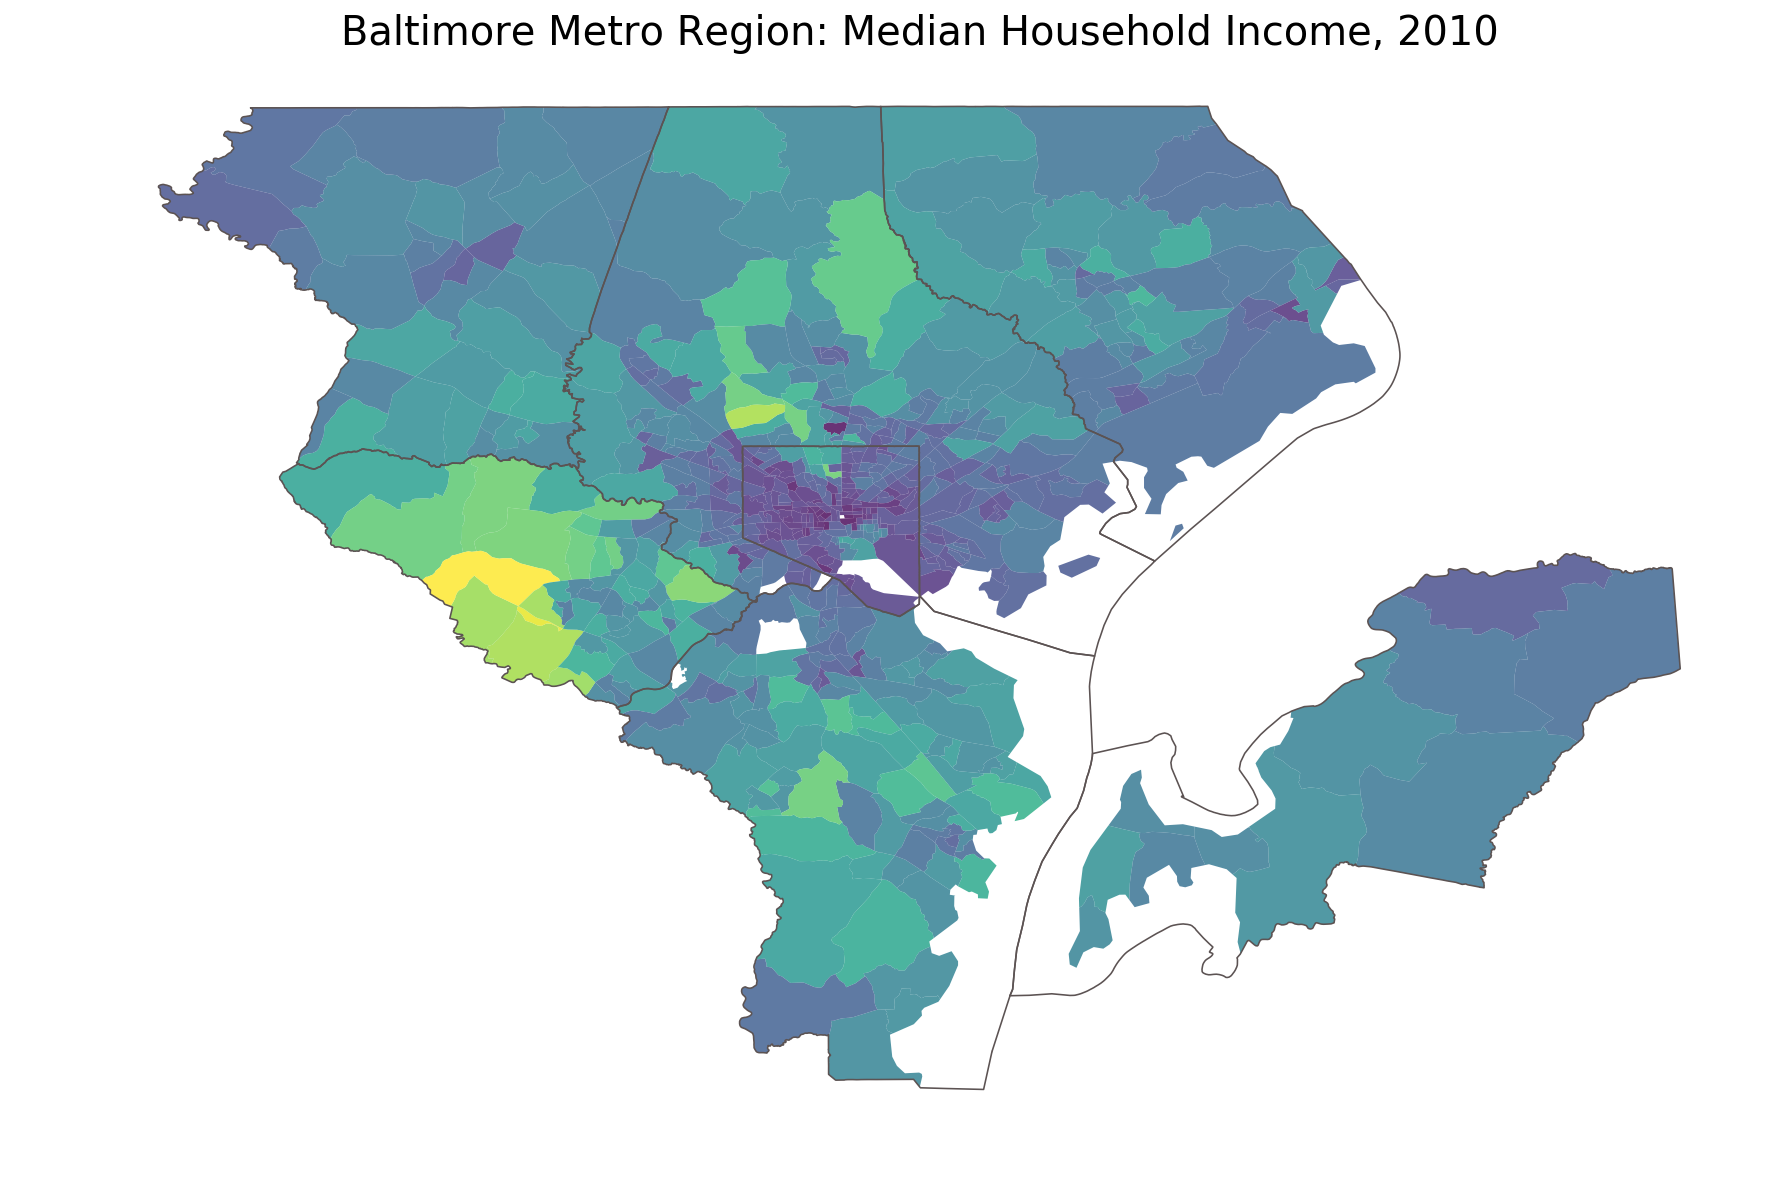

In [9]:
baltimore.plot(column='median_household_income', year=2010)

## Analyze neighborhood clusters

To facilitate geodemographic and other neighborhood typologies, the `osnap.analytics` module provides the `cluster` function. 

`cluster`takes a `Dataset`, a list of columns/variables, a clustering algorithm, and a number of clusters. It handles temporal clustering by splitting the dataset into decades and standardizing each variable, then re-pooling all the time periods back together before running the clustering algorithm on the full set of observations. This allows the distribution of each variable to evolve over time. It also allows neighborhood variables to move through different positions in the distrbution while providing a consistent set of clusters across time periods

In [10]:
c = osnap.analytics.cluster(baltimore, columns=['median_household_income', 'p_poverty_rate', 'p_edu_college_greater', 'p_unemployment_rate'], method='ward')

`cluster` returns a `Dataset` class with cluster labels appended as a new column on `data`. This makes it simple to visualize how the clusters have evolved in space over time

(-77.389756546738909, -75.669476518482895, 38.660578799999996, 39.7720232)

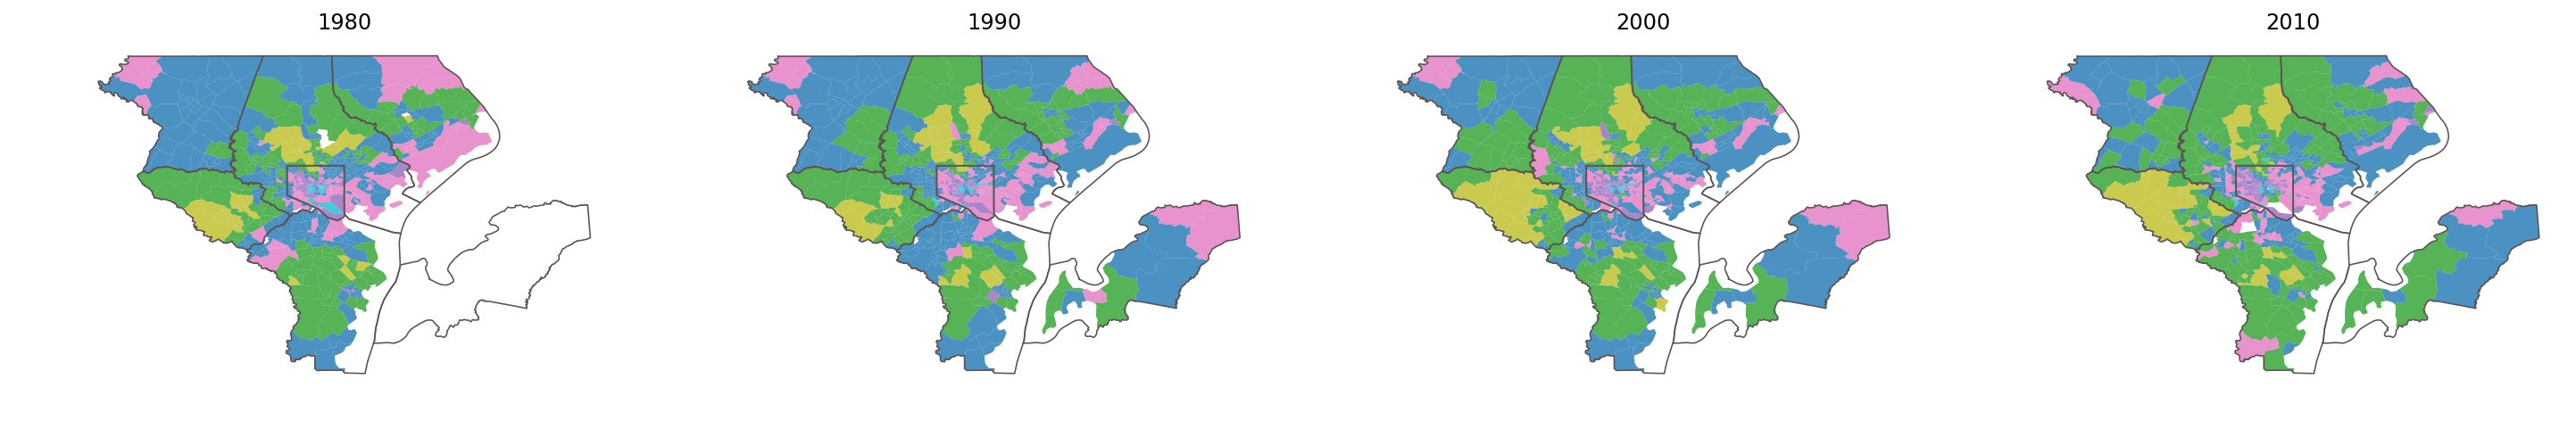

In [11]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(25, 10))

c.plot(column='ward', year=1980, ax=ax1)
ax1.set_title('1980')
ax1.axis('off')

c.plot(column='ward', year=1990, ax=ax2)
ax2.set_title('1990')
ax2.axis('off')

c.plot(column='ward', year=2000, ax=ax3)
ax3.set_title('2000')
ax3.axis('off')

c.plot(column='ward', year=2010, ax=ax4)
ax4.set_title('2010')
ax4.axis('off')

Since cluster labels are appended to the input database, it's also simple to compute and visualize statistics by cluster, even for variables that weren't used to derive the clusters

In [12]:
c.data.groupby('ward')['p_nonhisp_white_persons'].median()

ward
0    86.0
1    90.0
2     5.0
3    78.0
4    89.0
5     3.0
Name: p_nonhisp_white_persons, dtype: float64

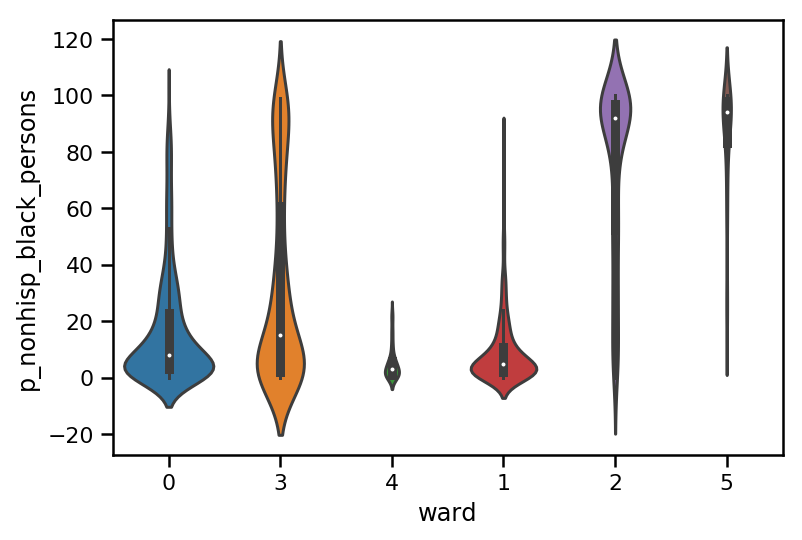

In [13]:
sns.violinplot(x="ward", y="p_nonhisp_black_persons", data=c.data, scale='count')